# Header

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
import janitor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os

exec(open("../header.py").read())

Header initialized


# Import

In [2]:
threshold = 40

In [3]:
raw_train_data = pd.read_csv(processed_root("03-bag-of-words/threshold-"+str(threshold)+"/bow_train_data.csv"))
raw_val_data = pd.read_csv(processed_root("03-bag-of-words/threshold-"+str(threshold)+"/bow_val_data.csv"))
raw_test_data = pd.read_csv(processed_root("03-bag-of-words/threshold-"+str(threshold)+"/bow_test_data.csv"))

In [4]:
X_train = raw_train_data\
    .drop(['poetry_text', 'poetry_author'], axis = 1)
X_val = raw_val_data\
    .drop(['poetry_text', 'poetry_author'], axis = 1)
y_train = raw_train_data['poetry_author']
y_val = raw_val_data['poetry_author']

In [5]:
len(X_train.columns)

1897

# Evaluate and Tune

In [38]:
def tuning_loop(max_depth_choices):
    
    train_accuracies = []
    val_accuracies = []

    for max_depth in max_depth_choices:
        rf = RandomForestClassifier(max_depth = max_depth, class_weight = "balanced")
        rf.fit(X_train, y_train)
        # Training
        y_pred_train = rf.predict(X_train)
        train_accuracy = np.mean(y_pred_train == y_train) * 100
        train_accuracies.append(train_accuracy)

        # Validation
        y_pred_val = rf.predict(X_val)
        val_accuracy = np.mean(y_pred_val == y_val) * 100
        val_accuracies.append(val_accuracy)
        
    return train_accuracies, val_accuracies

In [ ]:
max_depth_choices = [(i+1)*5 for i in range(30)]
train_accuracies, val_accuracies = tuning_loop(max_depth_choices)

In [55]:
def plot_results(md, train, val):
    fig, ax = plt.subplots()
    ax.plot(md, train, label = "Train")
    ax.plot(md, val, label = "Validation")
    ax.set_title("Random Forest Accuracy versus Max Depth")
    ax.set_xlabel("Max Depth")
    ax.set_ylabel("Accuracy (%)")
    ax.legend()
    
    print("Maximum validation accuracy, %.2f%% found at max depth of %d."\
      %(max(val), md[np.argmax(val)]))

Maximum validation accuracy, 57.48% found at max depth of 20.


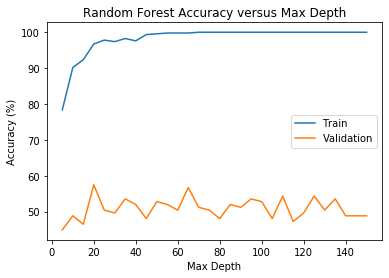

In [56]:
plot_results(max_depth_choices, train_accuracies, val_accuracies)

## Second tune

In [45]:
max_depth_choices2 = [i for i in range(15,26)]
train_accuracies2, val_accuracies2 = tuning_loop(max_depth_choices2)

Maximum validation accuracy, 57.48% found at max depth of 24.


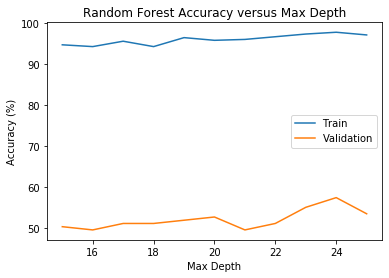

In [57]:
plot_results(max_depth_choices2, train_accuracies2, val_accuracies2)

# Best model

In [25]:
model = RandomForestClassifier(max_depth = 24, class_weight = 'balanced')

In [26]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=24, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
# No single feature accounting for things
np.max(model.feature_importances_)

0.02589319215977771

In [32]:
# Most important word
X_train.iloc[0:1,np.argmax(model.feature_importances_):np.argmax(model.feature_importances_)+1]

,amp
0,0


In [33]:
y_pred_val = model.predict(X_val)

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [38]:
author_labels = list(y_val.value_counts().index)

In [89]:
confusion_matrix(y_true = y_val, y_pred = y_pred_val, labels = author_labels)

array([[14,  0,  0,  2,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 5,  8,  0,  1,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  7,  3,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  1,  0,  0,  5,  0,  1,  0,  0,  1,  0,  0],
       [ 2,  0,  1,  3,  0,  3,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  1,  5,  0,  0,  0,  0,  0],
       [ 3,  0,  0,  1,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 2,  0,  1,  2,  1,  0,  0,  0,  2,  0,  0,  0],
       [ 3,  1,  0,  2,  0,  1,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  7,  0],
       [ 0,  0,  0,  6,  0,  0,  1,  0,  0,  0,  0,  0]], dtype=int64)

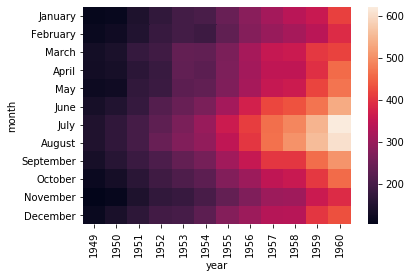

In [36]:
raw_flights = sn.load_dataset("flights")

flights = raw_flights.pivot("month", "year", "passengers")

ax = sn.heatmap(flights)

In [41]:
y_pred

NameError: name 'y_pred' is not defined

Text(32.99999999999999, 0.5, 'True')

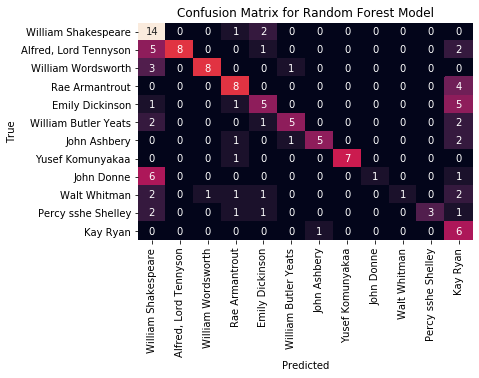

In [39]:
fig, ax = plt.subplots()

sn.heatmap(confusion_matrix(y_true = y_val, y_pred = y_pred_val, labels = author_labels), 
           annot = True,
           xticklabels = author_labels,
           yticklabels = author_labels,
           cbar = False,
           ax = ax)

ax.set_title("Confusion Matrix for Random Forest Model")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

In [40]:
ax

In [24]:
y_train.value_counts()

William Shakespeare      60
Alfred, Lord Tennyson    55
Rae Armantrout           44
William Wordsworth       42
Emily Dickinson          40
John Ashbery             33
William Butler Yeats     33
Percy sshe Shelley       31
Yusef Komunyakaa         31
John Donne               30
Walt Whitman             29
Kay Ryan                 29
Name: poetry_author, dtype: int64